In [2]:
import os
import time
import itertools
import calendar as cal
import numpy as np 
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import pacf, acf



# plotly settings
plotly_base_params = {
    'template': "plotly_white",
    'title_font': dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
    'font': dict(color='#8a8d93'), 
    'hoverlabel': dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif")
}

In [3]:
DATA_DIR = "/kaggle/input/store-sales-time-series-forecasting"

In [4]:
train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"), parse_dates=['date'])
test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"), parse_dates=['date'])
oil = pd.read_csv(os.path.join(DATA_DIR, "oil.csv"), parse_dates=['date'])
holidays_events = pd.read_csv(os.path.join(DATA_DIR, "holidays_events.csv"), parse_dates=['date'])
transactions = pd.read_csv(os.path.join(DATA_DIR, "transactions.csv"), parse_dates=['date'])
stores = pd.read_csv(os.path.join(DATA_DIR, "stores.csv"))

print(f"Training Data: from {train.date.min()} to {train.date.max()} - {train.date.max() - train.date.min()}")
print(f"Testing Data: from {test.date.min()} to {test.date.max()} - {test.date.max() - test.date.min()}")

Training Data: from 2013-01-01 00:00:00 to 2017-08-15 00:00:00 - 1687 days 00:00:00
Testing Data: from 2017-08-16 00:00:00 to 2017-08-31 00:00:00 - 15 days 00:00:00


In [5]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB
None


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [7]:
# calendar dataset covering train + test dates
calendar = pd.DataFrame(index=pd.date_range(train.date.min(), test.date.max()))
# days of week
calendar['weekday'] = calendar.index.dayofweek 

<a id="EDA"></a>
# EDA

In [8]:
# Extend training set for the EDA
train_ext = train.merge(stores, on='store_nbr', how='left')
train_ext = train_ext.merge(transactions, on=['date', 'store_nbr'], how='left')
train_ext = train_ext.rename(columns={"type": "store_type"})

In [9]:
# Parsing dates
train_ext['date'] = train_ext['date'].astype('datetime64[ns]')
train_ext['year'] = train_ext['date'].dt.year
train_ext['month'] = train_ext['date'].dt.month
train_ext['week'] = train_ext['date'].dt.isocalendar().week
train_ext['quarter'] = train_ext['date'].dt.quarter
train_ext['weekday'] = train_ext['date'].dt.dayofweek
train_ext['day_name'] = train_ext['date'].dt.day_name()

In [10]:
print("Extended training data:", train_ext.shape)
train_ext.head()

Extended training data: (3000888, 17)


,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,year,month,week,quarter,weekday,day_name
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,2013,1,1,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,2013,1,1,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,2013,1,1,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,2013,1,1,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,2013,1,1,1,1,Tuesday


<a id="sales"></a>
## Sales

In [11]:
def print_summary(data:dict, title):
    fig=go.Figure()
    fig.add_trace(go.Scatter(
        x=np.arange(start=0, stop=len(data)),
        y=np.full(len(data), 1.6),
        mode="text", 
        text=[f"<span style='font-size:33px'><b>{data[x]}</b></span>" for x in data],
        textposition="bottom center",
        hoverinfo='skip'
    ))
    fig.add_trace(go.Scatter(
        x=np.arange(start=0, stop=len(data)),
        y=np.full(len(data), 1.1),
        mode="text", 
        text=[x for x in data],
        textposition="bottom center",
        hoverinfo='skip'
    ))
    fig.add_hline(y=2.2, line_width=5, line_color='gray')
    fig.add_hline(y=0.3, line_width=3, line_color='gray')
    fig.update_yaxes(visible=False)
    fig.update_xaxes(visible=False)
    fig.update_layout(
        showlegend=False, height=300, width=1200,
        title=title, title_x=0.5, title_y=0.9,
        yaxis_range=[-0.2,2.2],
        plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
        font=dict(size=23, color='#323232'),
        title_font=dict(size=35, color='#222'),
        margin=dict(t=90,l=70,b=0,r=70)
    )
    fig.show(config={'staticPlot': False})

In [12]:
# compute number of months
start_date = train_ext.date.min()
end_date = train_ext.date.max()
nb_months = round((end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + (end_date.day / 30.5), 1)

summary = {
    "Stores": stores.shape[0],
    "Store types": train_ext.store_type.nunique(),
    "Store clusters": train_ext.cluster.nunique(),
    "Product families": train_ext.family.nunique(),
    "States": train_ext.state.nunique(),
    "Months": nb_months
}
print_summary(summary, "Stores Summary")

In [13]:
# data
df_sales = train.groupby('date').agg({"sales" : "sum"}).reset_index()
df_sales['sales_ma'] = df_sales['sales'].rolling(7).mean()
df_trans = train_ext.groupby('date').agg({"transactions" : "sum"}).reset_index()
df_trans['transactions_ma'] = df_trans['transactions'].rolling(7).mean()

# chart
fig = make_subplots(rows=3, cols=1,
                    subplot_titles=["Sales", "Transactions", "Sales / Transactions"],
                    vertical_spacing=.1)
fig.add_scatter(x=df_sales['date'], y=df_sales['sales'],
                mode='lines', marker=dict(color='#428bca'),
                name='Sales', row=1, col=1)
fig.add_scatter(x=df_sales['date'], y=df_sales['sales_ma'],
                mode='lines', marker=dict(color='#d9534f'),
                name='7d moving avearge', row=1, col=1)
fig.add_scatter(x=df_trans['date'], y=df_trans['transactions'],
                mode='lines', marker=dict(color='#428bca'),
                name='Transactions', row=2, col=1)
fig.add_scatter(x=df_trans['date'], y=df_trans['transactions_ma'],
                mode='lines', marker=dict(color='#d9534f'),
                name='7d moving avearge', row=2, col=1)
fig.add_scatter(x=df_sales['sales'], y=df_trans['transactions'],
                mode='markers', marker=dict(color='#428bca', size=2),
                name='Sales/Transactions', row=3, col=1)
# style
fig.update_xaxes(title='Sales', row=3, col=1)
fig.update_yaxes(title='Transactions', row=3, col=1)
fig.update_layout(height=750, width=1200, showlegend=False, **plotly_base_params)
fig.show()

In [14]:
# data c1
df_st_sa = train_ext.groupby('store_type').agg({"sales" : "mean"}).sort_values(by='sales', ascending=False).reset_index()
# data c2
df_fa_sa = train_ext.groupby('family').agg({"sales" : "mean"}).sort_values(by='sales', ascending=False)[:10].reset_index()
df_fa_sa['percent'] = round((df_fa_sa['sales'] / df_fa_sa['sales'].sum()) * 100, 1)
df_fa_sa['percent'] = df_fa_sa['percent'].astype(str) + "%"
df_fa_sa['color'] = '#c6ccd8'
df_fa_sa['color'].at[df_fa_sa.sales.idxmax()] = '#496595' # highest value color
# data c3
df_cl_sa = train_ext.groupby('cluster').agg({"sales" : "mean"}).reset_index()
df_cl_sa['percent'] = round((df_cl_sa['sales'] / df_cl_sa['sales'].sum()) * 100, 1)
df_cl_sa['percent'] = df_cl_sa['percent'].astype(str) + "%"
df_cl_sa['color'] = '#c6ccd8'
df_cl_sa['color'].at[df_cl_sa.sales.idxmax()] = '#496595'

# charts
fig = make_subplots(rows=2, cols=2,
                    column_widths=[0.5, 0.5], vertical_spacing=0, horizontal_spacing=0.02,
                    specs=[[{"type": "bar"}, {"type": "pie"}], [{"colspan": 2}, None]],
                    subplot_titles=("Top 10 Highest Product Sales", "Sales per Store Types", "Sales per Clusters"))
fig.add_trace(go.Bar(x=df_fa_sa['sales'], y=df_fa_sa['family'], text=df_fa_sa['percent'],
                     marker=dict(color=df_fa_sa['color']), name='Family', orientation='h'),
              row=1, col=1)
fig.add_trace(go.Pie(values=df_st_sa['sales'], labels=df_st_sa['store_type'],
                     name='Store type', hole=0.7,
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']),
                     hoverinfo='label+percent+value', textinfo='label'),
              row=1, col=2)
fig.add_trace(go.Bar(x=df_cl_sa['cluster'], y=df_cl_sa['sales'], text=df_cl_sa['percent'],
                     marker=dict(color=df_cl_sa['color']), name='Cluster'), 
              row=2, col=1)

# styling
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_cl_sa.cluster, ticktext=[i for i in range(1,17)], row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=500, width=1000, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  showlegend=False, **plotly_base_params)
fig.show()

Groceries and beverages account for more than half of these stores' sales.

In [15]:
# data
df_m_sa = train_ext.groupby('month').agg({"sales" : "mean"}).reset_index()
df_m_sa['sales'] = round(df_m_sa['sales'], 2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: cal.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['sales'].astype(str)
df_m_sa['color'] = '#c6ccd8'
df_m_sa['color'].at[df_m_sa.sales.idxmax()] = '#496595'

df_dw_sa = train_ext.groupby('weekday').agg({"sales" : "mean"}).reset_index()
df_dw_sa.sales = round(df_dw_sa.sales, 2)
df_dw_sa['day_name'] = df_dw_sa['weekday'].apply(lambda x: cal.day_name[x])
df_dw_sa['text'] = df_dw_sa['day_name'] + ' - ' + df_m_sa['sales'].astype(str)
df_dw_sa['color'] = '#c6ccd8'
df_dw_sa['color'].at[df_dw_sa.sales.idxmax()] = '#496595'

df_w_sa = train_ext.groupby('week').agg({"sales" : "mean"}).reset_index()
df_q_sa = train_ext.groupby('quarter').agg({"sales" : "mean"}).reset_index()
df_w_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=3,
                    vertical_spacing=0.08,
                    row_heights=[0.7, 0.3],
                    specs=[[{"type": "bar"}, {"type": "pie"}, {"type": "bar"}], [{"colspan": 3}, None, None]],
                    subplot_titles=("Month wise Avg Sales Analysis",
                                    "Quarter wise Avg Sales Analysis",
                                    "Day wise Avg Sales Analysis",
                                    "Week wise Avg Sales Analysis"))
# Row 1
fig.add_trace(go.Bar(x=df_m_sa['sales'], y=df_m_sa['month'][::-1],
                     marker=dict(color=df_m_sa['color']),
                     text=df_m_sa['text'], textposition='auto',
                     name='Month', orientation='h'), row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['sales'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']),
                     hole=0.7, hoverinfo='label+percent+value', textinfo='label+percent'), row=1, col=2)
fig.add_trace(go.Bar(x=df_dw_sa['sales'], y=df_dw_sa['weekday'][::-1],
                     marker=dict(color=df_dw_sa['color']),
                     text=df_dw_sa['text'], textposition='auto',
                     name='Day', orientation='h'), row=1, col=3)
# Row 2
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['sales'],
                         mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                         marker=dict(color='#496595'), name='Week'), row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_yaxes(visible=False, row=1, col=3)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_layout(height=500, width=1000, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Sales Analysis Over Time",
                  showlegend=False, **plotly_base_params)
fig.show()

Sales are more important on Sundays and for the Christmas holidays.

<a id="seasonality"></a>
### Seasonality

In [16]:
# source: https://gist.github.com/tomron/8798256fcee5438edd58c17654adf443
def plot_seasonal_decompose(result: DecomposeResult, title="Seasonal Decomposition"):
    return (
        make_subplots(rows=4, cols=1, subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"])
        .add_trace(go.Scatter(x=result.seasonal.index, y=result.observed, mode="lines", name="Observed"),
                   row=1, col=1)
        .add_trace(go.Scatter(x=result.trend.index, y=result.trend, mode="lines", name="Trend"),
                   row=2, col=1)
        .add_trace(go.Scatter(x=result.seasonal.index, y=result.seasonal, mode="lines", name="Seasonal"),
                   row=3, col=1)
        .add_trace(go.Scatter(x=result.resid.index, y=result.resid, mode="lines", name="Residuals"),
                   row=4, col=1)
        .update_layout(template="plotly_white", height=1250, width=1000, title=title, margin=dict(t=100), title_x=0.5, showlegend=False)
    )

In [17]:
seasonnal = seasonal_decompose(df_sales.set_index('date')['sales'], model='multiplicative', period=365)
plot_seasonal_decompose(seasonnal, title="Annual Seasonal Decomposition of Sales")

In [18]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq, y=y, data=X, hue=period, ci=False,
        ax=ax, palette=palette, legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name, xy=(1, y_), xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points", size=14, va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    # fs = (exact value of deprecated '1Y') / '1D'
    fs = pd.Timedelta('365 days 05:49:12') / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts, fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels([
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
        ], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [19]:
df_sales = df_sales.set_index('date').to_period("D")
# days within a week
df_sales['day'] = df_sales.index.dayofweek # the x-axis (freq)
df_sales['week'] = df_sales.index.week # the seasonal period (period)

# days within a year
df_sales['dayofyear'] = df_sales.index.dayofyear
df_sales['year'] = df_sales.index.year
df_sales['month'] = df_sales.index.month

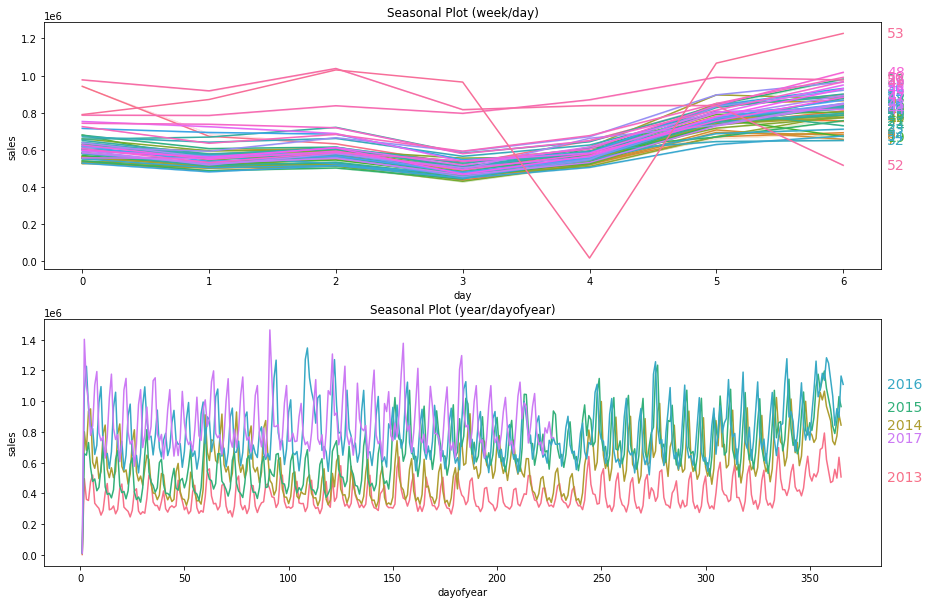

In [20]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 10))
seasonal_plot(df_sales, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(df_sales, y="sales", period="year", freq="dayofyear", ax=ax1)
plt.show()

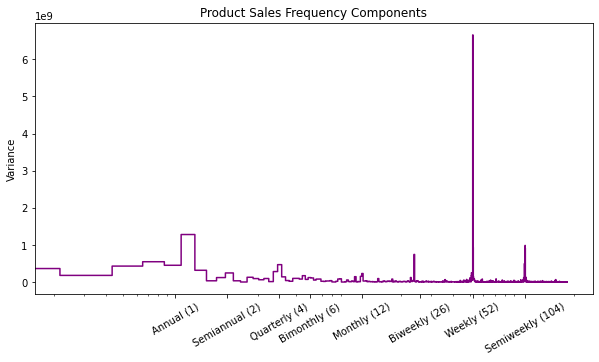

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = plot_periodogram(df_sales["sales"], ax=ax)
ax.set_title("Product Sales Frequency Components")
plt.show()

In [22]:
df = train.groupby(['date', 'family']).agg({"sales" : "sum"})
df = df.unstack(level=0).T.droplevel(level=0, axis=0).rolling(7).mean()
fig =  go.Figure()
for col in df.columns:
    fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col, mode='lines'))
fig.update_layout(height=850,
                  title_text="Weekly moving average per product Family",
                  **plotly_base_params)
fig.show()

It is possible to choose the curves to be displayed by clicking on the product families. (double click on a family to display only this family)

We can clearly see different trends according to the product families.  
There are also sales that appear to be stable in periodicity but undergo large increases/decreases (while maintaining the same periodicity). This may be the result of the conglomerate's desire to increase/decrease its sales of this type of product. For example: DAIRY

The sales of the following products are much lower than the other product families: 'AUTOMOTIVE', 'BEAUTY', 'CELEBRATION', 'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'

<a id="oil"></a>
## Oil Price

In [23]:
# compute 7-days moving average
oil['ma_oil'] = oil['dcoilwtico'].rolling(7).mean()
oil = oil.set_index('date')

# adding oil price to calendar
calendar['ma_oil'] = oil['ma_oil'].loc[train.date.min():test.date.max()]
calendar['ma_oil'].fillna(method='ffill', inplace=True)

In [24]:
# chart
fig = go.Figure()
fig.add_scatter(x=oil.index, y=oil.dcoilwtico,
                mode='lines', name='Oil Price',
                line=dict(color='#428bca', width=2))
fig.add_scatter(x=oil.index, y=oil.ma_oil.fillna(method='ffill'),
                mode='lines', name='7d moving avergae',
                line=dict(color='purple', width=1))
fig.update_layout(title='Avg Sales with Holydays and Events', **plotly_base_params)
fig.show()

In [25]:
train_ext = train_ext.merge(oil, on='date', how='left')

fig = px.imshow(train_ext[['ma_oil', 'sales', 'transactions']].corr(), color_continuous_scale='reds')
fig.update_layout(title='Correlation between Oil / Sales / Transactions', height=400, width=700, **plotly_base_params)

Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.  
It can be seen that the oil price is almost not correlated with the sales of shops that sell mainly food products.

In [26]:
print("Correlation between oil price and :")
for f in train_ext.family.unique():
    df = train_ext[train_ext.family == f][['sales', 'ma_oil']].copy()
    corr = df.corr().unstack().drop_duplicates().unstack()['ma_oil'].values[0]
    print(f" - {f}: {corr:.3f}")

Correlation between oil price and :
 - AUTOMOTIVE: -0.152
 - BABY CARE: -0.105
 - BEAUTY: -0.218
 - BEVERAGES: -0.358
 - BOOKS: -0.090
 - BREAD/BAKERY: -0.194
 - CELEBRATION: -0.312
 - CLEANING: -0.181
 - DAIRY: -0.240
 - DELI: -0.231
 - EGGS: -0.121
 - FROZEN FOODS: -0.089
 - GROCERY I: -0.216
 - GROCERY II: -0.063
 - HARDWARE: -0.085
 - HOME AND KITCHEN I: -0.313
 - HOME AND KITCHEN II: -0.394
 - HOME APPLIANCES: 0.028
 - HOME CARE: -0.500
 - LADIESWEAR: -0.286
 - LAWN AND GARDEN: -0.169
 - LINGERIE: 0.065
 - LIQUOR,WINE,BEER: -0.084
 - MAGAZINES: -0.390
 - MEATS: -0.029
 - PERSONAL CARE: -0.234
 - PET SUPPLIES: -0.332
 - PLAYERS AND ELECTRONICS: -0.358
 - POULTRY: -0.132
 - PREPARED FOODS: -0.085
 - PRODUCE: -0.348
 - SCHOOL AND OFFICE SUPPLIES: -0.096
 - SEAFOOD: -0.044


**Oil Lag Features**  

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points.  
PACF, also measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [27]:
def plot_acf_pacf(series, n_lags=20, plot_pacf=False):
    corr_array = pacf(series.dropna(), alpha=0.05, nlags=n_lags) if plot_pacf else acf(series.dropna(), alpha=0.05, fft=False, nlags=n_lags)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]
    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0],
                    mode='markers', marker_color='#1f77b4', marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y,
                    mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y,
                    mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
                    fill='tonexty', line_color='rgba(255,255,255,0)',
                    name='No-correlation interval')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,n_lags+1])
    fig.update_yaxes(zerolinecolor='#000000')
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title, height=500, width=1000)
    fig.show()

In [28]:
def make_lags(ts, lags):
    return pd.concat(
        {f'{ts.name}_lag_{i}': ts.shift(i) for i in range(1, lags + 1)},
        axis=1
    )

In [29]:
plot_acf_pacf(calendar['ma_oil'].dropna(), plot_pacf=False)
plot_acf_pacf(calendar['ma_oil'].dropna(), plot_pacf=True)

In [30]:
# add lagged oil features to calendar
oil_lags = make_lags(calendar['ma_oil'], 4).fillna(method='ffill')
calendar = calendar.join(oil_lags)

<a id="events"></a>
## Holidays / Events

In [31]:
mask = holidays_events.description=='Viernes Santo'
holidays_events[mask]

,date,type,locale,locale_name,description,transferred
51,2013-04-29,Holiday,National,Ecuador,Viernes Santo,False
99,2014-04-18,Holiday,National,Ecuador,Viernes Santo,False
166,2015-04-03,Holiday,National,Ecuador,Viernes Santo,False
215,2016-03-25,Holiday,National,Ecuador,Viernes Santo,False
306,2017-04-14,Holiday,National,Ecuador,Viernes Santo,False


There is an error in the events/holidays dataset. According to the [2013 list of holidays in Ecuador](https://www.turismo.gob.ec/wp-content/uploads/downloads/2014/01/Feriados-20131.pdf), Good Friday was March 29th, not April 29th.

In [32]:
# 'Good Friday' mistake correction
holidays_events['date'][mask].replace({'2013-04-29': pd.to_datetime('2013-03-29')}, inplace=True)
holidays_events = holidays_events.set_index('date').sort_index()
# keep National level only for simplicity
holidays_events = holidays_events[holidays_events.locale=='National']
# keep only one event per day
holidays_events = holidays_events.groupby(holidays_events.index).first()

In [33]:
# data
avg_sales = train.groupby('date').agg({"sales" : "mean"}).reset_index()
df_s_he = avg_sales.merge(holidays_events, on='date', how='left')
df_s_he = df_s_he.rename(columns={"type": "event_type"})


# chart
fig = go.Figure()
fig.add_scatter(x=df_s_he.date, y=df_s_he.sales,
                mode='lines', name='Avg Sales', line=dict(width=.5))
fig.add_scatter(x=df_s_he['date'][df_s_he.event_type=='Holiday'],
                y=df_s_he['sales'][df_s_he.event_type=='Holiday'],
                mode='markers', name='Holidays',
                marker=dict(color='orange', size=4))
fig.add_scatter(x=df_s_he['date'][df_s_he.event_type=='Event'],
                y=df_s_he['sales'][df_s_he.event_type=='Event'],
                mode='markers', name='Events',
                marker=dict(color='purple', size=5))
fig.update_layout(title='Avg Sales with Holydays and Events',
                  height=500, width=1000, **plotly_base_params)
fig.show()

- New Year's Day is the only day when all stores are closed
- The earthquake in 2016 led to an increase in sales

In [34]:
# correction of workdays using holidays/events dates

def compute_workdays(df, dofw_col):
    df['workday'] = True
    # exclude week-ends
    df.loc[df[dofw_col] > 4, 'workday'] = False
    # friday bridges are not working days
    df.loc[df.event_type=='Bridge', 'workday'] = False
    # some bridges are recovered by working at weekends
    df.loc[df.event_type=='Work Day', 'workday'] = True
    # handling Transfered events
    df.loc[df.event_type=='Transfer', 'workday'] = False
    df.loc[(df.event_type=='Holiday')&(df.transferred==False), 'workday'] = False
    df.loc[(df.event_type=='Holiday')&(df.transferred==True ), 'workday'] = True
    return df                 

In [35]:
# holidays / events
calendar = calendar.merge(holidays_events, how='left', left_index=True, right_index=True)
calendar = calendar.rename(columns={"type": "event_type"})
# days of work
calendar = compute_workdays(calendar, 'weekday')
calendar['workday'] = calendar['workday'] * 1
calendar.drop(columns=['locale', 'locale_name', 'description', 'transferred'], inplace=True)